In [27]:
%run ./function.ipynb

# load data

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.special import entr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, KDTree
from math import log

In [29]:
PATH = 'C:/Users/NCTUUser2/Desktop/mark/'
FILE = 'TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv'
df = pd.read_csv(PATH + FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [30]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [31]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************


C:\Users\NCTUUser2\AppData\Local\Temp\4\ipykernel_11576\2736333543.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train_Non_SAR.append(train_TO_SAR)
C:\Users\NCTUUser2\AppData\Local\Temp\4\ipykernel_11576\2736333543.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = test_Non_SAR.append(test_TO_SAR)


time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


In [32]:
train_set = train_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
test_set = test_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
print(f'train_set:{train_set.shape}\n' + f'test_set:{test_set.shape}')

train_set:(52060, 38)
test_set:(34709, 38)


In [33]:
SAR = train_set[train_set.TO_SAR!= 0]
Non_SAR = train_set[train_set.TO_SAR== 0]

# Function

In [34]:
def Entropy(data, feature):
    total_cnt = len(data)
    if total_cnt == 0:
        return 0
    else:
        target_cnt = np.array([len(data[data[feature] == 0]), len(data[data[feature] != 0])])
        pk = target_cnt / total_cnt
        vec = entr(pk)
        S = np.sum(vec, axis= 0)
        S /= np.log(2) # 換底公式
        return S

In [166]:
def gradientIG(point, x_name, y_name, data):
    K = 2
    while True:
        _, auxiliary_idx = credit_kdtree.query(point.flatten(), k= K)
        auxiliary_idx = auxiliary_idx[-1]
        auxiliary = data.loc[auxiliary_idx, [x_name, y_name]].to_numpy().reshape(2,1)

        if auxiliary.all() != point.all():
            break
        K += 10
    
    delta = auxiliary - point
    tmp1 = np.array([[float(auxiliary[0])], [float(point[0])]])
    tmp2 = np.array([[float(point[0])], [float(auxiliary[1])]])

    z = informationGain(point, x_name, y_name, data)
    z_delta_x = informationGain(tmp1, x_name, y_name, data)
    z_delta_y = informationGain(tmp2, x_name, y_name, data)
    z_delta = np.array([[z_delta_x], [z_delta_y]])

    return (z_delta - z) / delta
    


In [76]:
def gradientIG(point, x_name, y_name, data):
    _, auxiliary_idx = credit_kdtree.query(point.flatten(), k= 2)
    auxiliary_idx = auxiliary_idx[-1]
    auxiliary = train_set.loc[auxiliary_idx, [x_name, y_name]].to_numpy().reshape(2,1)
    delta = auxiliary - point
    z = informationGain(point, x_name, y_name, data)
    z_delta = [informationGain(np.array([[auxiliary[[0]]], point[[1]]]), x_name, y_name, data), \
        informationGain(np.array([[point[[0]]], auxiliary[[1]]]), x_name, y_name, data)]
    grad = (z_delta - z) / delta

    return grad

In [79]:
def conditionalEntropy(new_sam_0 , new_sam_1):
    total = len(new_sam_1) + len(new_sam_0)
    return Entropy(new_sam_0, SAR_type) * (len(new_sam_0) / total) \
            + Entropy(new_sam_1, SAR_type) * (len(new_sam_1) / total)

In [37]:
def informationGain(point, x_name, y_name, data):
    
    idx1 = set(data[data[x_name] >= float(point[0])].index)
    idx2 = set(data[data[y_name] >= float(point[1])].index)
    
    #idx3 = set(data[data[y_name] >= float(y_thre)].index)
    
    idx = list(idx1 & idx2)
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    #print(len(new_sam_1), len(new_sam_0))
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 0 and new sam 1 are overlapped')
        
    return -(father_entropy - conditionalEntropy(new_sam_0, new_sam_1))

In [38]:
def Recall(point, x_name, y_name, data):
    idx1 = set(data[data[x_name] > float(point[0])].index)
    idx2 = set(data[data[y_name] > float(point[1])].index)
    idx = list(idx1 & idx2)
    #print(f'idx:{len(idx)}')
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new sam 1 and new sam 0 are overlapped')
    
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    return -(TP / (TP + FN))

In [39]:
def RecallFilterRate(point, x_name, y_name, data):
    idx1 = set(data[data[x_name] > float(point[0])].index)
    idx2 = set(data[data[y_name] > float(point[1])].index)
    
    idx = list(idx1 & idx2)
    
    new_sam_1 = data.iloc[idx]
    new_sam_0 = data.drop(index= new_sam_1.index)
    
    if len(set(new_sam_1.index) & set(new_sam_0.index)) != 0:
        raise ValueError('new_sam_1 and new_sam_0 are voerlapped')
        
    TP = new_sam_1[new_sam_1[SAR_type] != 0].shape[0]
    TN = new_sam_0[new_sam_0[SAR_type] == 0].shape[0]
    FP = new_sam_1[new_sam_1[SAR_type] == 0].shape[0]
    FN = new_sam_0[new_sam_0[SAR_type] != 0].shape[0]
    
    recall = TP / (TP + FN)
    filter_rate = (TN + FN) / (TP + TN + FP + FN)
    
    return recall, filter_rate

In [40]:
def plot_results(results):
    x = list(results.loc[results['iteration number'] % 50 == 0].index)
    x.append(len(results) - 1)

    plt.figure()
    plt.plot(x, results.loc[x, 'information gain'], 'o--')
    plt.plot(x, results.loc[x, 'recall'], 'o--')
    plt.plot(x, results.loc[x, 'filter rate'], 'o--')
    plt.xlabel('iteration number')

    plt.legend(['information gain', 'recall', 'filter rate'])
    plt.show()

In [41]:
def plot_seperator(results):
    x = list(results.loc[results['iteration number'] % 50 == 0].index)
    x.append(len(results) - 1)

    plot_name = ['information gain', 'recall', 'filter rate']
    color = ['r', 'b', 'g']
    plt.figure()
    for i, name in enumerate(plot_name):
        plt.subplot(2,2,i+1)
        plt.plot(x, results.loc[x, name], 'o--', color= color[i])
        plt.title(name)
    plt.tight_layout()
    plt.show()

In [42]:
def gradientPenalty(point, upperbound=np.zeros((2,1))):
    if np.any(point < 0): # any 是只要有一個是 True 就 output True，但 all 是要全部都為 True 才 output True
        raise ValueError('point are negative!')

    if np.linalg.norm(upperbound) == 0:
        return 1 / point
    else:
        return 1 / (upperbound - point)

In [43]:
def gradientRecall(point, x_name, y_name, data):
    x1 = float(point[0])
    y1 = float(point[1])

    if len(np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')) > auxiliary_point_select_behind_x:
        x2 = np.sort(np.unique(data.loc[data[x_name] > x1, x_name]), kind= 'stable')[auxiliary_point_select_behind_x]
    else:
        x2 = np.sort(np.unique(data.loc[data[x_name] < x1, x_name]), kind= 'stable')[-auxiliary_point_select_behind_x]
    
    if len(np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')) > auxiliary_point_select_behind_y:
        y2 = np.sort(np.unique(data.loc[data[y_name] > y1, y_name]), kind= 'stable')[auxiliary_point_select_behind_y]
    else:
        y2 = np.sort(np.unique(data.loc[data[y_name] < y1, y_name]), kind= 'stable')[-auxiliary_point_select_behind_y]
    
    delta_x = x2 - x1
    delta_y = y2 - y1

    z = Recall(point, x_name, y_name, data)
    z_delta_x = Recall(np.array([[x2], [y1]]), x_name, y_name, data)
    z_delta_y = Recall(np.array([[x1], [y2]]), x_name, y_name, data)

    grad = np.array([[(z_delta_x - z) / delta_x], [(z_delta_y - z) / delta_y]])

    return grad

In [44]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-(sigmoid_b + sigmoid_w * x)))

In [45]:
def sigmoidDiff(x):
    tmp = sigmoid(x)
    return tmp * (1 - tmp)

In [179]:
def loss_func(point, IG, Recall):
    x = float(point[0])
    y = float(point[1])
    loss = IG * sigmoid(Recall) + gamma * (log(x) + log(y) + log(Mx - x) + log(My - y))
    return loss

In [186]:
def BFGSWithUpDownPenaltyRecall(point0, x_name, y_name, upperbound, data):
    results = pd.DataFrame(columns= ['iteration number', 'x1', 'y1', 'new x1', 'new y1', 'information gain', 'recall', 'filter rate', 'loss'])
    d = 2
    gradIG = gradientIG(point0, x_name, y_name, data)
    gradRecall = gradientRecall(point0, x_name, y_name, data)
    gradientPenaltyDown = gradientPenalty(point0)
    gradientPenaltyUp = gradientPenalty(point0, upperbound)
    recall = Recall(point0, x_name, y_name, data)
    information_gain = informationGain(point0, x_name, y_name, data)
    grads = gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * gradRecall + gamma * (gradientPenaltyDown + gradientPenaltyUp)
    print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
    H = np.eye(d)
    point = point0
    n = 1

    print(f'gradIG:\n{gradIG}')
    print(f'gradRecall:\n{gradRecall}')
    print(f'gradPenaltyDown:\n{gradientPenaltyDown}')
    print(f'gradPenaltyUp:\n{gradientPenaltyUp}')
    print(f'Hessian matrix:\n{H}')


    while np.linalg.norm(grads) > 1e-50:
        if n > N_max:
            print(f'maximum iteration reached!')
            break
        
        update_direction = -H @ grads
        print(f'update_direction:\n{update_direction}')
        new_point = point + step_size * update_direction

        information_gain = informationGain(new_point, x_name, y_name, data)
        recall, filter_rate = RecallFilterRate(new_point, x_name, y_name, data)
        loss = loss_func(point, information_gain, recall)

        print(f'n={n}, new x1:{float(new_point[0])}, new y1: {float(new_point[1])},\ninformation gain: {information_gain}, recall:{recall}, filter rate:{filter_rate}')

        tmp_results = pd.DataFrame({'iteration number': n, 'x1': float(point[0]), 'y1': float(point[1]), 'new x1': float(new_point[0]), \
                                 'new y1': float(new_point[1]), 'information gain': information_gain, 'recall': recall, \
                                 'filter rate': filter_rate, 'loss': loss}, index= [n])
        results = pd.concat([results, tmp_results])

        new_gradIG = gradientIG(new_point, x_name, y_name, data)
        new_gradRecall = gradientRecall(new_point, x_name, y_name, data)
        new_gradPenaltyDown = gradientPenalty(new_point)
        new_gradPenaltyUp = gradientPenalty(new_point, upperbound)
        new_grads = new_gradIG * sigmoid(recall) + information_gain * sigmoidDiff(recall) * new_gradRecall + gamma * (new_gradPenaltyDown + new_gradPenaltyUp)

        y = new_grads - grads
        s = new_point - point
        denominator = 1 / (y.T @ s)
        li = np.eye(d) - (denominator * (s @ y.T))
        ri = np.eye(d) - (denominator * (y @ s.T))
        H = li @ H @ ri + (denominator * (s @ s.T))

        grads = new_grads
        point = new_point
        print('*'*32)
        print(f'new_gradIG:\n{new_gradIG}')
        print(f'new_gradRecall:\n{new_gradRecall}')
        print(f'new_gradPenaltyDown:\n{new_gradPenaltyDown}')
        print(f'new_gradPenaltyUp:\n{new_gradPenaltyUp}')
        print(f'new_Hessian matrix:\n{H}')
        print(f'recall:{recall}, sigmoid:{sigmoid(recall)}')
        
        n += 1

    if np.linalg.norm(grads) < 1e-50:
        print('Early stopping')
    
    return results

# find the higher recall in the Credit_Amt and number_of_Credit

In [55]:
point = train_set[['Credit_Amt', 'number_of_Credit']]
credit_kdtree = cKDTree(point, leafsize= 100)

In [47]:
tmp = (SAR.loc[:, 'Credit_Amt'].to_numpy()**2 + SAR.loc[:, 'number_of_Credit'].to_numpy())**(1/2)
SAR.insert(0,'SAR_Credit_distance', tmp)

del tmp 

In [48]:
idx_SAR_Credit_distance = SAR.loc[SAR['SAR_Credit_distance']!=0].sort_values(by= 'SAR_Credit_distance').index

print(len(idx_SAR_Credit_distance))

109 235


In [49]:
credit_distance_results = pd.DataFrame(columns= ['Credit_Amt', 'number_of_Credit', 'recall', 'filterRate'])

for idx in idx_SAR_Credit_distance:
    x, y = SAR.loc[idx][['Credit_Amt', 'number_of_Credit']]
    recall_tmp, filterRate_tmp= RecallFilterRate(np.array([[x], [y]]), 'Credit_Amt', 'number_of_Credit', train_set)
    tmp = pd.DataFrame({'Credit_Amt':[x], 'number_of_Credit':[y], 'recall': [recall_tmp], 'filterRate': [filterRate_tmp]})
    credit_distance_results = pd.concat([credit_distance_results, tmp])

In [115]:
point0 = credit_distance_results.sort_values(by= 'recall', ascending= False).iloc[0,0:2]
point0 = point0.to_numpy().reshape(2,1)

Credit_Amt          4000.0
number_of_Credit       1.0
Name: 0, dtype: float64

In [176]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Credit_Amt'
y_name = 'number_of_Credit'
step_size = 0.001
gamma = 1e-5
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
upperbound = np.array([[train_set[x_name].max()], [train_set[y_name].max()]])
sigmoid_b = 0.8
sigmoid_w = 5
Mx = train_set[x_name].max()
My = train_set[y_name].max()
father_entropy = Entropy(train_set, SAR_type)

In [183]:
print('point',point)
data = train_set
K = 2

while True:
    _, auxiliary_idx = credit_kdtree.query(point.flatten(), k= K)
    auxiliary_idx  = auxiliary_idx[-1]
    auxiliary = train_set.loc[auxiliary_idx, [x_name, y_name]].to_numpy().reshape(2, 1)
    print('K=',K,'aux',auxiliary)
    if auxiliary.all() != point.all():
        break
    K += 10
# _, auxiliary_idx = credit_kdtree.query(point.flatten(), k= 100)
# auxiliary_idx  =auxiliary_idx[-1]
# auxiliary = train_set.loc[auxiliary_idx, [x_name, y_name]].to_numpy().reshape((2,1))

delta = auxiliary - point
tmp1 = np.array([[float(auxiliary[0])], [float(point[0])]])
tmp2 = np.array([[float(point[0])], [float(auxiliary[1])]])
z = informationGain(point, x_name, y_name, data)
# #z_delta_x  = informationGain(np.array([[float(auxiliary[0])], float(point[1])]), x_name, y_name, data)
# #z_delta_y = informationGain(np.array([[float(point[0])], float(auxiliary[1])]), x_name, y_name, data)
# # z_delta = [informationGain(np.array([[float(auxiliary[0])], float(point[1])]), x_name, y_name, data), \
# #         informationGain(np.array([[float(point[0])], float(auxiliary[1])]), x_name, y_name, data)]
z_delta_x = informationGain(tmp1, x_name, y_name, data)
z_delta_y = informationGain(tmp2, x_name, y_name, data)
z_delta = np.array([[z_delta_x], [z_delta_y]])
grad = (z_delta - z) / delta
print(grad)

point [[4.e+03]
 [1.e+00]]
K= 2 aux [[4000.0]
 [1.0]]
K= 12 aux [[4000.0]
 [1.0]]
K= 22 aux [[4000.0]
 [1.0]]
K= 32 aux [[4050.0]
 [1.0]]
K= 42 aux [[3617.0]
 [2.0]]
[[-2.057901597944917e-06]
 [0.00013225031909248897]]


In [187]:
if __name__ == '__main__':
    np.random.seed(1111)
    print(point0)
    results = BFGSWithUpDownPenaltyRecall(point0, x_name, y_name, upperbound, train_set)

[[4.e+03]
 [1.e+00]]
recall:-0.37453183520599254, sigmoid:0.2548977114266221
gradIG:
[[-2.057901597944917e-06]
 [0.00013225031909248897]]
gradRecall:
[[0.        ]
 [0.02434457]]
gradPenaltyDown:
[[2.5e-04]
 [1.0e+00]]
gradPenaltyUp:
[[4.30839491e-08]
 [1.17508813e-03]]
Hessian matrix:
[[1. 0.]
 [0. 1.]]
update_direction:
[[5.220539768178572e-07]
 [-4.007781173011453e-05]]
n=1, new x1:4000.000000000522, new y1: 0.9999999599221883,
information gain: -0.0008364830183348743, recall:0.40074906367041196, filter rate:0.36519400691509796
********************************
new_gradIG:
[[-1602304.5384953993]
 [0.0]]
new_gradRecall:
[[0.        ]
 [0.02996255]]
new_gradPenaltyDown:
[[0.00024999999999996737]
 [1.0000000400778133]]
new_gradPenaltyUp:
[[4.3083949074772195e-08]
 [0.00117508813155453]]
new_Hessian matrix:
[[-3.4300160195389024e-16 -1.2257644879474482e-07]
 [-1.2257644879474482e-07 5894.643623701278]]
recall:0.40074906367041196, sigmoid:0.9428778788088424
update_direction:
[[-5.17137362

In [188]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate,loss
996,996,4000.0,1.025028,4000.0,1.025051,-0.000656,0.374532,0.416654,-0.000293
997,997,4000.0,1.025051,4000.0,1.025075,-0.000656,0.374532,0.416654,-0.000293
998,998,4000.0,1.025075,4000.0,1.025098,-0.000656,0.374532,0.416654,-0.000293
999,999,4000.0,1.025098,4000.0,1.025121,-0.000656,0.374532,0.416654,-0.000293
1000,1000,4000.0,1.025121,4000.0,1.025145,-0.000656,0.374532,0.416654,-0.000293


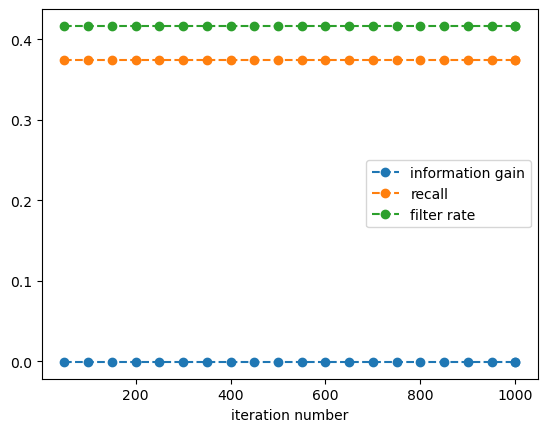

In [189]:
plot_results(results)

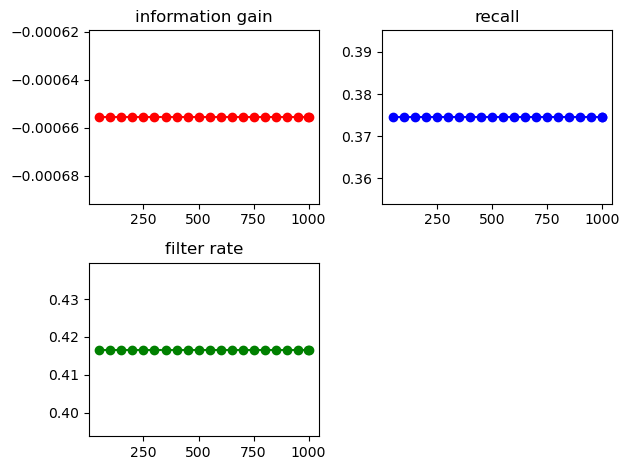

In [190]:
plot_seperator(results)

## Find the higher recall in the Debit_Amt and number_of_Debit

In [ ]:
print('point',point)
data = train_set
K = 2

while True:
    _, auxiliary_idx = credit_kdtree.query(point.flatten(), k= K)
    auxiliary_idx  = auxiliary_idx[-1]
    auxiliary = train_set.loc[auxiliary_idx, [x_name, y_name]].to_numpy().reshape(2, 1)
    print('K=',K,'aux',auxiliary)
    if auxiliary.all() != point.all():
        break
    K += 10
# _, auxiliary_idx = credit_kdtree.query(point.flatten(), k= 100)
# auxiliary_idx  =auxiliary_idx[-1]
# auxiliary = train_set.loc[auxiliary_idx, [x_name, y_name]].to_numpy().reshape((2,1))

delta = auxiliary - point
tmp1 = np.array([[float(auxiliary[0])], [float(point[0])]])
tmp2 = np.array([[float(point[0])], [float(auxiliary[1])]])
z = informationGain(point, x_name, y_name, data)
# #z_delta_x  = informationGain(np.array([[float(auxiliary[0])], float(point[1])]), x_name, y_name, data)
# #z_delta_y = informationGain(np.array([[float(point[0])], float(auxiliary[1])]), x_name, y_name, data)
# # z_delta = [informationGain(np.array([[float(auxiliary[0])], float(point[1])]), x_name, y_name, data), \
# #         informationGain(np.array([[float(point[0])], float(auxiliary[1])]), x_name, y_name, data)]
z_delta_x = informationGain(tmp1, x_name, y_name, data)
z_delta_y = informationGain(tmp2, x_name, y_name, data)
z_delta = np.array([[z_delta_x], [z_delta_y]])
grad = (z_delta - z) / delta
print(grad)

point [[4.e+03]
 [1.e+00]]
K= 2 aux [[4000.0]
 [1.0]]
K= 12 aux [[4000.0]
 [1.0]]
K= 22 aux [[4000.0]
 [1.0]]
K= 32 aux [[4050.0]
 [1.0]]
K= 42 aux [[3617.0]
 [2.0]]
[[-2.057901597944917e-06]
 [0.00013225031909248897]]


In [192]:
debit_kdtree = cKDTree(train_set[['Debit_Amt', 'number_of_Debit']], leafsize= 100)

In [ ]:
tmp = (SAR.loc[:, 'Debit_Amt'].to_numpy()**2 + SAR.loc[:, 'number_of_Debit'].to_numpy())**(1/2)
SAR.insert(0, 'SAR_Debit_distance', tmp)

del tmp

In [ ]:
idx_SAR_Debit_distance = SAR.loc[SAR['SAR_Debit_distance']!=0].sort_values(by= 'SAR_Debit_distance').index
print(len(idx_SAR_Debit_distance))

In [193]:
debit_distance_results = pd.DataFrame(columns = ['Debit_Amt', 'number_of_Debit', 'recall', 'filterRate'])

for idx in idx_SAR_Debit_distance:
    x, y = SAR.loc[idx][['Debit_Amt', 'number_of_Debit']]
    recall_tmp, filterRate_tmp = RecallFilterRate(np.array([[x], [y]]), 'Debit_Amt', 'number_of_Debit', train_set)
    tmp = pd.DataFrame({'Debit_Amt': [x], 'number_of_Debit': [y], 'recall': [recall_tmp], 'filterRate': [filterRate_tmp]})
    debit_distance_results = pd.concat([debit_distance_results, tmp])

In [198]:
point0 = debit_distance_results.sort_values(by= 'recall', ascending= False).iloc[0, 0:2]
point0 = point0.to_numpy().reshape(2,1)

In [200]:
#hyperparameter
SAR_type = 'TO_SAR'
eps = 1e-1000
N_max = 1000
x_name = 'Debit_Amt'
y_name = 'number_of_Debit'
step_size = 0.001
gamma = 1e-5
auxiliary_point_select_behind_x = 3
auxiliary_point_select_behind_y = 3
upperbound = np.array([[train_set[x_name].max()], [train_set[y_name].max()]])
sigmoid_b = 0.8
sigmoid_w = 5
Mx = train_set[x_name].max()
My = train_set[y_name].max()
father_entropy = Entropy(train_set, SAR_type)

In [201]:
if __name__ == '__main__':
    np.random.seed(1111)

    print(point0)
    results = BFGSWithUpDownPenaltyRecall(point0, x_name, y_name, upperbound, train_set)

[[1000.]
 [   1.]]
recall:-0.8164794007490637, sigmoid:0.036180037363314814
gradIG:
[[5.997171622561205e-10]
 [1.707592602885011e-05]]
gradRecall:
[[0.        ]
 [0.02059925]]
gradPenaltyDown:
[[0.001]
 [1.   ]]
gradPenaltyUp:
[[1.26696145e-08]
 [5.61797753e-03]]
Hessian matrix:
[[1. 0.]
 [0. 1.]]
update_direction:
[[-1.0021824485482485e-08]
 [-1.012960157842706e-05]]
n=1, new x1:999.99999999999, new y1: 0.9999999898703984,
information gain: -0.0007578625779430595, recall:0.8801498127340824, filter rate:0.31185170956588554
********************************
new_gradIG:
[[5.997171622561205e-10]
 [1.7075926020987733e-05]]
new_gradRecall:
[[3.34403424e-05]
 [3.12109862e-02]]
new_gradPenaltyDown:
[[0.00100000000000001]
 [1.0000000101296016]]
new_gradPenaltyUp:
[[1.2669614463631871e-08]
 [0.0056179775277701805]]
new_Hessian matrix:
[[1.0000009234617906 -2.661283191335221e-05]
 [-2.661283191335221e-05 -0.0006036730641742504]]
recall:0.8801498127340824, sigmoid:0.9945177866277554
update_directi

In [202]:
results.tail()

,iteration number,x1,y1,new x1,new y1,information gain,recall,filter rate,loss
996,996,999.700952,1.496867,999.700951,1.496869,-0.00062,0.82397,0.361391,-0.000308
997,997,999.700951,1.496869,999.698295,1.501280,-0.00062,0.82397,0.361391,-0.000308
998,998,999.698295,1.501280,999.698296,1.501277,-0.00062,0.82397,0.361391,-0.000308
999,999,999.698296,1.501277,999.700401,1.497783,-0.00062,0.82397,0.361391,-0.000308
1000,1000,999.700401,1.497783,999.700400,1.497785,-0.00062,0.82397,0.361391,-0.000308


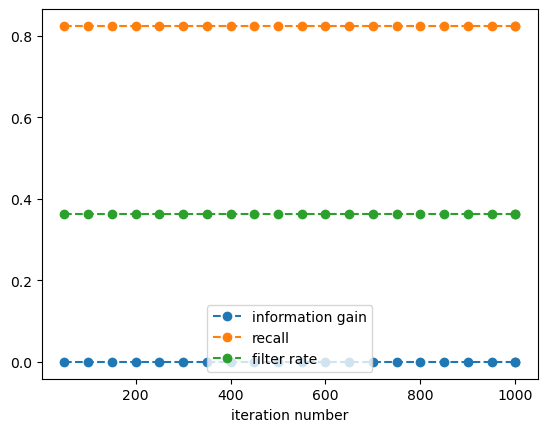

In [203]:
plot_results(results)

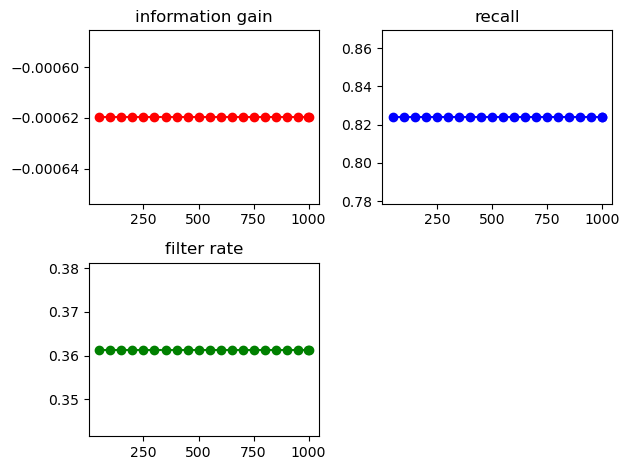

In [204]:
plot_seperator(results)

## We expand to the four dimension, which contained "Credit_Amt", "number_of_Credit", "Debit_Amt", "number_of_Debit " 